# MPI calibration of a Grid'5000 cluster

In this notebook, we use [pycewise](https://pypi.org/project/pycewise/) to compute a segmented linear regression on our calibration data. The experiment has been done on a Grid'5000 cluster called dahu, using peanut experiment engine. The result of the experiment is therefore a zip archive, containing various data and metada files.

In case the experiment has not been realised with peanut, this notebook can easily be adapted to directly read the CSV files of interest in a given directory.

In [1]:
import io
import pandas
import zipfile
import yaml
import matplotlib.pyplot as plt

import pycewise
print(f'pycewise {pycewise.__version__}')
print(f'pycewise {pycewise.__git_version__}')

archive = '../data/grenoble_2020-08-13_1944311.zip'

# Theoretical bandwidth and latency values
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

expected_loopback_bandwidth = 2e11/8
expected_loopback_latency = 1e-7

pycewise 0.1.3
pycewise 9b6d8d852be30416a685e1d622c3edeee4724a23


In the next cell, we define several function to read the data in the archive.

In [2]:
def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def extract_zip(zip_name):
    '''
    Return a dictionnary containing all the (parsed) files of the given archive, depending on the file extensions.
    - CSV files are loaded as pandas dataframes.
    - Yaml files are loaded as Python dictionnaries.
    - Other files are not parsed, the raw string is kept.

    Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['type'] = name
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name), Loader=yaml.BaseLoader)
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    '''
    Aggregate the given dataframe by averaging all the durations by message size.
    '''
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

def load_experiment(zip_name):
    '''
    Read an MPI calibration experiment in the given archive (with some basic pre-processing of the data).
    '''
    result = extract_zip(zip_name)
    semantic_breaks = result['breakpoints'].decode().strip().split('\n')[-2:]
    semantic_breaks = [int(b.split(':')[1]) for b in semantic_breaks]
    # Special processing for the Pingpong dataset
    df_pingpong = result['exp/exp_PingPong.csv']
    pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
    df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration
                  ))
    result = {
        'pingpong': df_pingpong,
        'send'  : pingpong_send,
        'isend' : result['exp/exp_Isend.csv'],
        'recv'  : result['exp/exp_Recv.csv'],
        'wtime' : result['exp/exp_Wtime.csv'],
        'test'  : result['exp/exp_Test.csv'],
        'iprobe': result['exp/exp_Iprobe.csv'],
    }
    return result, semantic_breaks

In [3]:
experiment, semantic_breaks = load_experiment(archive)
semantic_breaks

[64000, 64000]

## First regressions

Alright, so we have our two semantic breakpoints (which are in fact equal here, there is no `detached` mode on this cluster). Now, let's compute the regressions.

### MPI_Send

In [4]:
%%time

tmp = aggregate_dataframe(experiment['send'])
reg_send = pycewise.compute_regression(x=tmp.msg_size, y=tmp.duration, mode='log').auto_simplify()
breakpoints_send = set(reg_send.breakpoints)
print(breakpoints_send)
reg_send

{8, 63785, 8141, 3761, 33975, 285420699}
CPU times: user 1min 28s, sys: 673 ms, total: 1min 29s
Wall time: 1min 28s


-inf < x ≤ 8.000e+00
	y ~ 5.740e-42x + 1.955e-07
8.000e+00 < x ≤ 3.761e+03
	y ~ 8.335e-11x + 2.662e-07
3.761e+03 < x ≤ 8.141e+03
	y ~ 1.412e-10x + 4.123e-08
8.141e+03 < x ≤ 3.398e+04
	y ~ 1.073e-10x + 3.811e-06
3.398e+04 < x ≤ 6.378e+04
	y ~ 1.457e-10x + 7.443e-06
6.378e+04 < x ≤ 2.854e+08
	y ~ 8.084e-11x + 1.604e-05
2.854e+08 < x ≤ inf
	y ~ 8.155e-11x + 9.702e-03

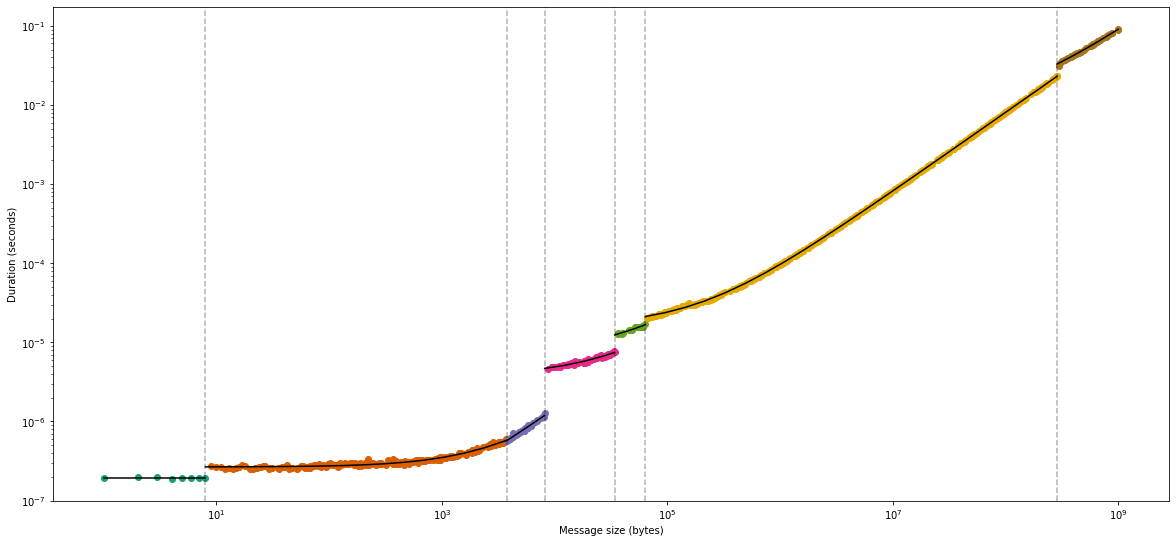

In [5]:
def draw_plot(reg, alpha=1):
    reg.plot_dataset(log=True, alpha=alpha)
    plt.xlabel('Message size (bytes)')
    plt.ylabel('Duration (seconds)')

draw_plot(reg_send)

### MPI_Isend

In [6]:
%%time

tmp = aggregate_dataframe(experiment['isend'])
reg_isend = pycewise.compute_regression(x=tmp.msg_size, y=tmp.duration, mode='log').auto_simplify()
breakpoints_isend = set(reg_isend.breakpoints)
print(breakpoints_isend)
reg_isend

{10208, 99962271, 63785, 10, 15182, 193591133, 4153567}
CPU times: user 1min 19s, sys: 360 ms, total: 1min 20s
Wall time: 1min 19s


-inf < x ≤ 1.000e+01
	y ~ 4.531e-08x + 4.819e-07
1.000e+01 < x ≤ 1.021e+04
	y ~ 6.433e-11x + 7.741e-07
1.021e+04 < x ≤ 1.518e+04
	y ~ 4.364e-11x + 1.510e-06
1.518e+04 < x ≤ 6.378e+04
	y ~ 3.274e-11x + 3.320e-06
6.378e+04 < x ≤ 4.154e+06
	y ~ 4.137e-14x + 7.924e-07
4.154e+06 < x ≤ 9.996e+07
	y ~ 4.240e-15x + 8.680e-07
9.996e+07 < x ≤ 1.936e+08
	y ~ 2.737e-48x + 1.236e-06
1.936e+08 < x ≤ inf
	y ~ 1.563e-16x + 1.503e-06

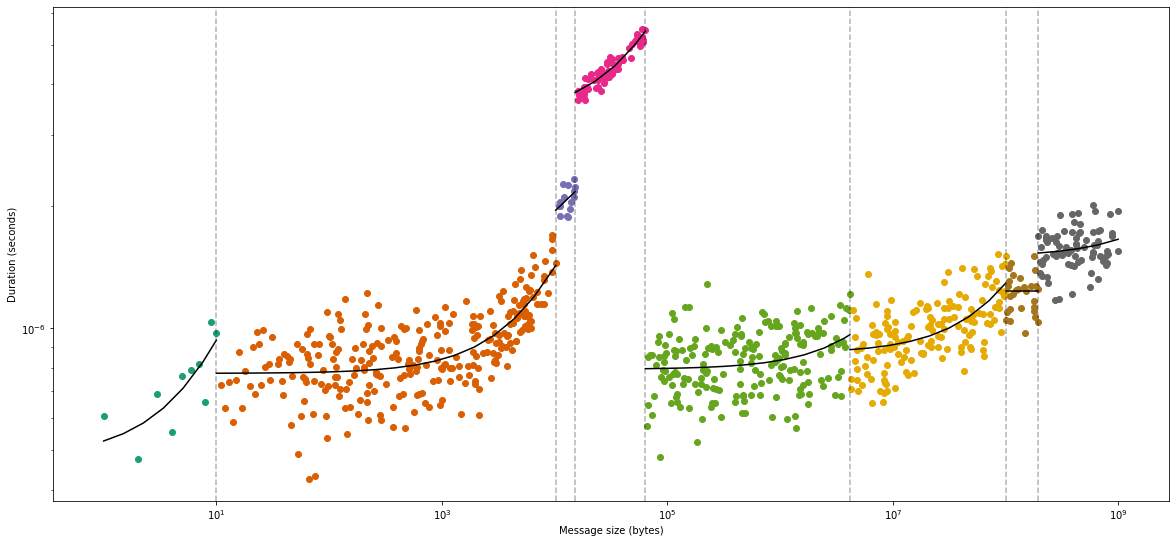

In [7]:
draw_plot(reg_isend)

In [8]:
breakpoints_isend = set(reg_isend.breakpoints)
breakpoints_isend

{10, 10208, 15182, 63785, 4153567, 99962271, 193591133}

### MPI_Recv

In [9]:
%%time

tmp = aggregate_dataframe(experiment['recv'])
reg_recv = pycewise.compute_regression(x=tmp.msg_size, y=tmp.duration, mode='log').auto_simplify()
breakpoints_recv = set(reg_recv.breakpoints)
print(breakpoints_recv)
reg_recv

{8, 63785}
CPU times: user 59.4 s, sys: 71.2 ms, total: 59.5 s
Wall time: 59.4 s


-inf < x ≤ 8.000e+00
	y ~ 1.080e-09x + 1.027e-06
8.000e+00 < x ≤ 6.378e+04
	y ~ 7.144e-11x + 1.272e-06
6.378e+04 < x ≤ inf
	y ~ 8.130e-11x + 9.434e-06

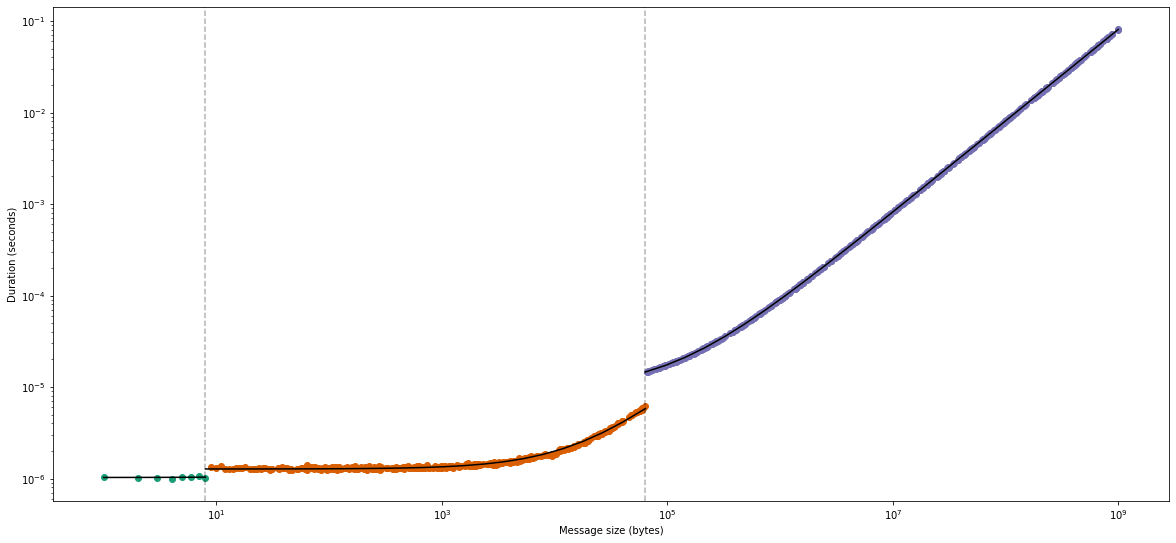

In [10]:
draw_plot(reg_recv)

### Pingpong

In [11]:
%%time

tmp = aggregate_dataframe(experiment['pingpong'])
reg_pingpong = pycewise.compute_regression(x=tmp.msg_size, y=tmp.duration, mode='log').auto_simplify()
breakpoints_pingpong = set(reg_pingpong.breakpoints)
print(breakpoints_pingpong)
reg_pingpong

{16457, 285420699, 63785}
CPU times: user 1min 10s, sys: 156 ms, total: 1min 10s
Wall time: 1min 10s


-inf < x ≤ 1.646e+04
	y ~ 4.970e-10x + 2.818e-06
1.646e+04 < x ≤ 6.378e+04
	y ~ 4.205e-10x + 1.136e-06
6.378e+04 < x ≤ 2.854e+08
	y ~ 1.620e-10x + 2.624e-05
2.854e+08 < x ≤ inf
	y ~ 1.632e-10x + 9.584e-03

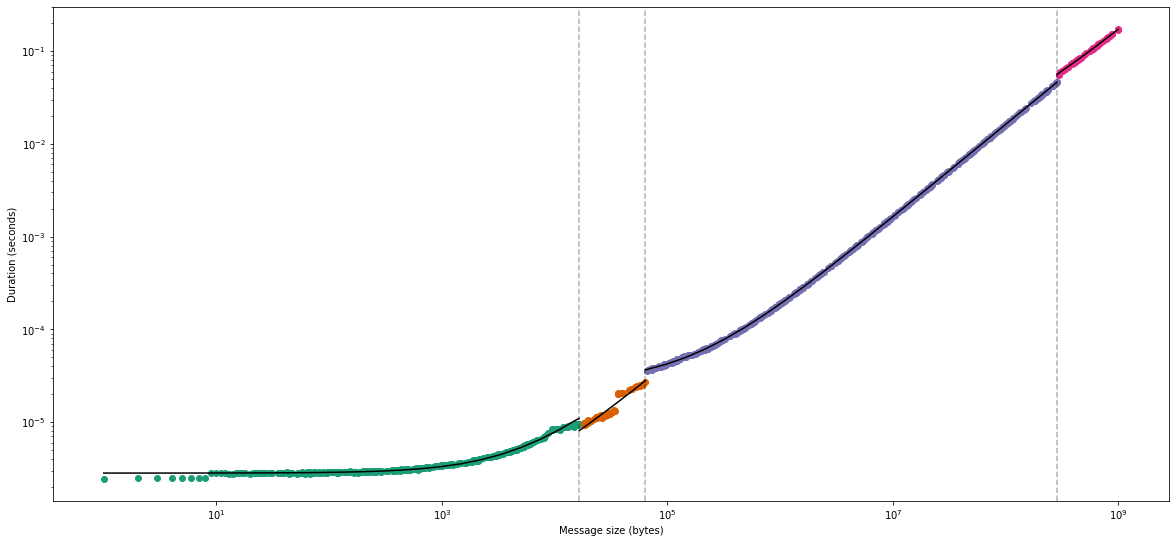

In [12]:
draw_plot(reg_pingpong)

## Better regressions

Let's use the same breakpoints everywhere. Here we take the union of all breakpoints, then we remove the ones we don't need (based on a visual inspection). We also replace the breakpoint(s) near the semantic breakpoints by the semantic breakpoints.

In the following, we also generate the platform file for SMPI.

In [13]:
drop_thresh = max(semantic_breaks)
drop_thresh  # used to generate the OS, OI and OR lines in the platform file

64000

In [14]:
computed_breakpoints = [int(b) for b in sorted(set.union(breakpoints_send, breakpoints_isend, breakpoints_recv, breakpoints_pingpong))]
computed_breakpoints

[8,
 10,
 3761,
 8141,
 10208,
 15182,
 16457,
 33975,
 63785,
 4153567,
 99962271,
 193591133,
 285420699]

In [15]:
remove = {8, 10, 3761, 10208, 16457, 63785, 4153567, 99962271, 193591133}
breakpoints = set(computed_breakpoints) - remove | set(semantic_breaks)
breakpoints = list(sorted(breakpoints))
breakpoints

[8141, 15182, 33975, 64000, 285420699]

In [16]:
def my_join(*values, inner_sep=':', outer_sep=';'):
    result = []
    for items in zip(*values):
        result.append(inner_sep.join([str(it) for it in items]))
    return outer_sep.join(result)

def regression_to_str(reg_df, drop_threshold=None, keys=['intercept', 'coefficient']):
    if drop_threshold is not None:
        reg_df.loc[reg_df.min_x >= drop_threshold, 'intercept'] = 0
        reg_df.loc[reg_df.min_x >= drop_threshold, 'coefficient'] = 0
    reg_df.loc[reg_df.min_x < 0, 'min_x'] = 0
    reg_df.min_x = reg_df.min_x.astype(int)
    reg_df.loc[reg_df.coefficient < 0, 'coefficient'] = 0
    reg_df.loc[reg_df.intercept < 0, 'intercept'] = 0
    reg_df.sort_values(by='min_x')
    values = [reg_df.min_x]
    for key in keys:
        values.append(reg_df[key])
    return my_join(*values)

### MPI_Send

-inf < x ≤ 8.141e+03
	y ~ 9.655e-11x + 2.569e-07
8.141e+03 < x ≤ 1.518e+04
	y ~ 1.331e-10x + 3.539e-06
1.518e+04 < x ≤ 3.398e+04
	y ~ 1.144e-10x + 3.614e-06
3.398e+04 < x ≤ 6.400e+04
	y ~ 1.457e-10x + 7.443e-06
6.400e+04 < x ≤ 2.854e+08
	y ~ 8.084e-11x + 1.604e-05
2.854e+08 < x ≤ inf
	y ~ 8.155e-11x + 9.702e-03


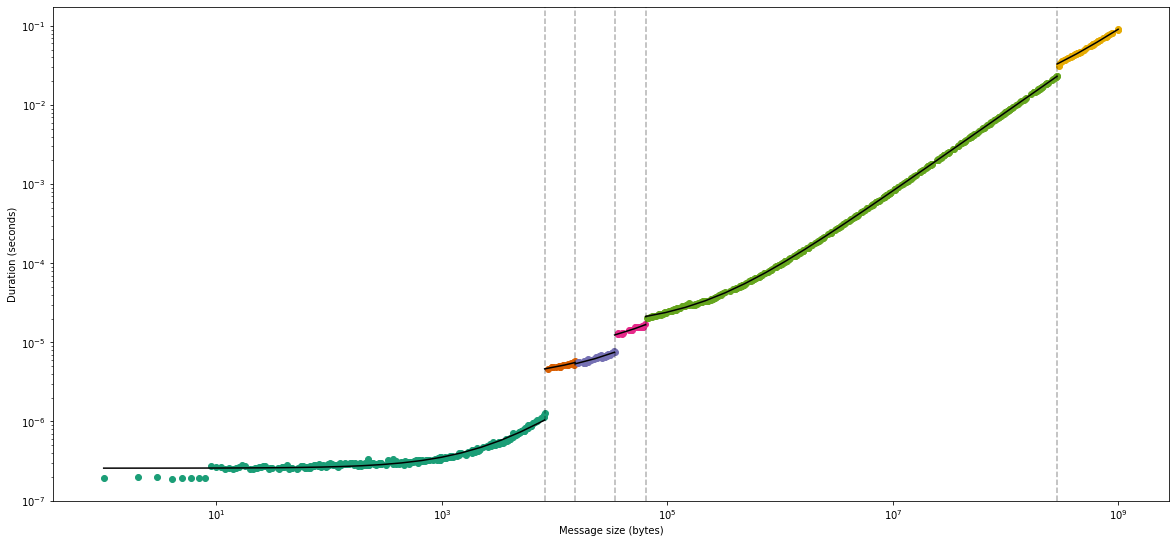

In [17]:
tmp = aggregate_dataframe(experiment['send'])
reg_send = pycewise.compute_regression(x=tmp.msg_size, y=tmp.duration, mode='log', breakpoints=breakpoints)
print(reg_send)
draw_plot(reg_send)

In [18]:
reg_send_str = regression_to_str(reg_send.to_pandas(), drop_threshold=drop_thresh)
reg_send_str

'0:2.569478959380802e-07:9.654903326895022e-11;8141:3.539145436762284e-06:1.3314821274741587e-10;15182:3.6144692297995343e-06:1.1444081092957802e-10;33975:7.442771050907994e-06:1.4571053896673637e-10;64000:0.0:0.0;285420699:0.0:0.0'

### MPI_Isend

-inf < x ≤ 8.141e+03
	y ~ 6.265e-11x + 7.713e-07
8.141e+03 < x ≤ 1.518e+04
	y ~ 1.192e-10x + 4.747e-07
1.518e+04 < x ≤ 3.398e+04
	y ~ 3.914e-11x + 3.163e-06
3.398e+04 < x ≤ 6.400e+04
	y ~ 3.105e-11x + 3.398e-06
6.400e+04 < x ≤ 2.854e+08
	y ~ 3.065e-15x + 8.502e-07
2.854e+08 < x ≤ inf
	y ~ 1.051e-16x + 1.537e-06


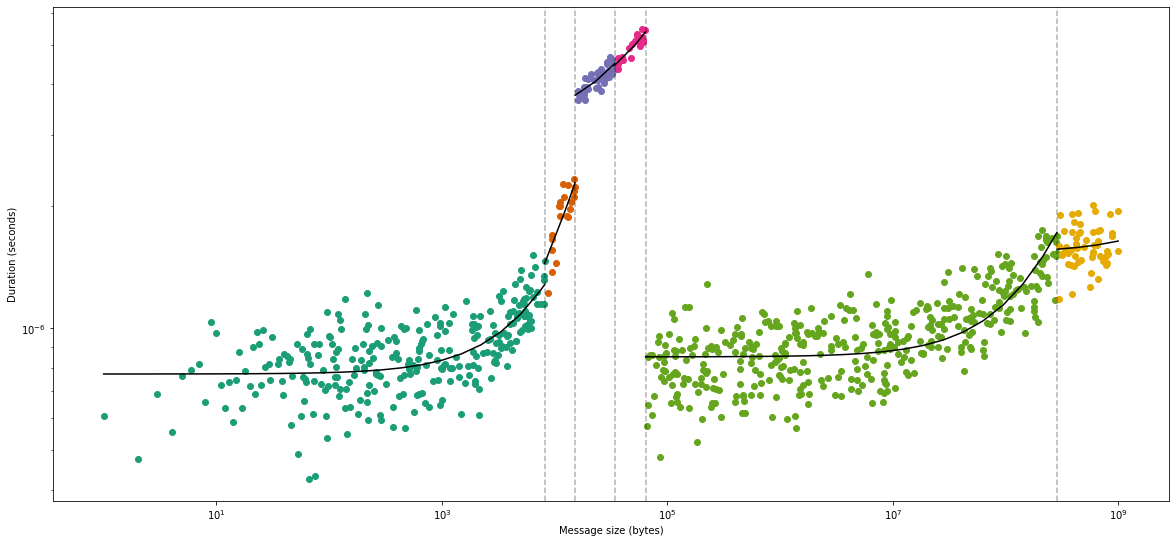

In [19]:
tmp = aggregate_dataframe(experiment['isend'])
reg_isend = pycewise.compute_regression(x=tmp.msg_size, y=tmp.duration, mode='log', breakpoints=breakpoints)
print(reg_isend)
draw_plot(reg_isend)

In [20]:
reg_isend_str = regression_to_str(reg_isend.to_pandas())
reg_isend_str

'0:7.713106893972037e-07:6.265045293286823e-11;8141:4.746573648378263e-07:1.1916323032290763e-10;15182:3.163310534066029e-06:3.913788923652584e-11;33975:3.3980189569161344e-06:3.104961875744934e-11;64000:8.502012071658028e-07:3.0649189436622192e-15;285420699:1.537212690372013e-06:1.0509048158790775e-16'

### MPI_Recv

-inf < x ≤ 8.141e+03
	y ~ 6.613e-11x + 1.275e-06
8.141e+03 < x ≤ 1.518e+04
	y ~ 7.774e-11x + 1.117e-06
1.518e+04 < x ≤ 3.398e+04
	y ~ 7.537e-11x + 1.144e-06
3.398e+04 < x ≤ 6.400e+04
	y ~ 7.892e-11x + 1.099e-06
6.400e+04 < x ≤ 2.854e+08
	y ~ 8.085e-11x + 9.894e-06
2.854e+08 < x ≤ inf
	y ~ 8.118e-11x + 8.906e-05


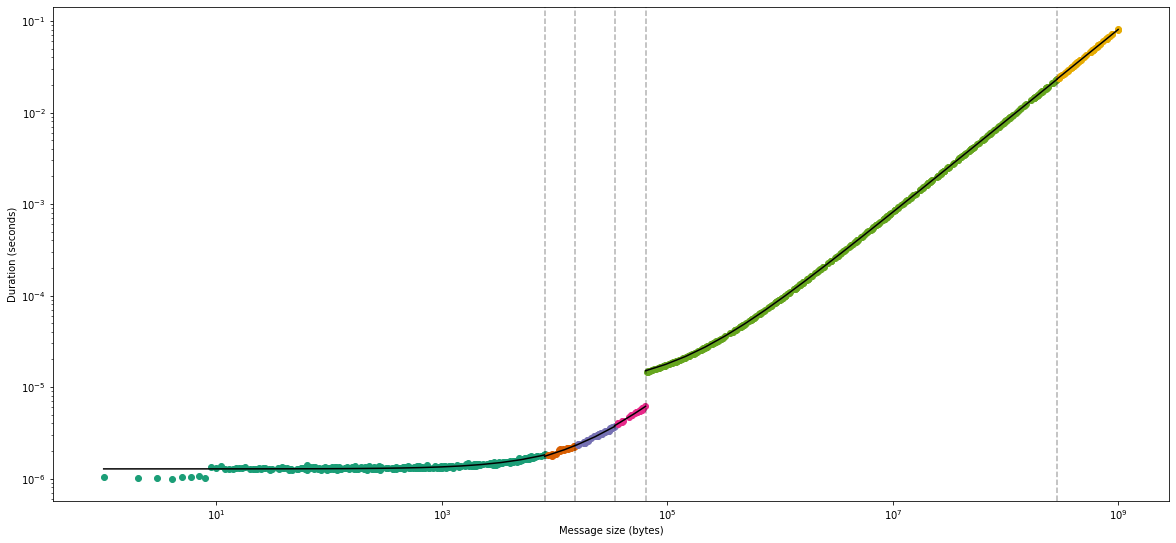

In [21]:
tmp = aggregate_dataframe(experiment['recv'])
reg_recv = pycewise.compute_regression(x=tmp.msg_size, y=tmp.duration, mode='log', breakpoints=breakpoints)
print(reg_recv)
draw_plot(reg_recv)

In [22]:
reg_recv_str = regression_to_str(reg_recv.to_pandas(), drop_threshold=drop_thresh)
reg_recv_str

'0:1.2750423139975955e-06:6.613419848852234e-11;8141:1.1174370543346335e-06:7.773513740535477e-11;15182:1.1443600853337174e-06:7.53731108392213e-11;33975:1.0993400801879667e-06:7.892046873378636e-11;64000:0.0:0.0;285420699:0.0:0.0'

### Pingpong

-inf < x ≤ 8.141e+03
	y ~ 5.121e-10x + 2.814e-06
8.141e+03 < x ≤ 1.518e+04
	y ~ 2.110e-10x + 6.176e-06
1.518e+04 < x ≤ 3.398e+04
	y ~ 2.237e-10x + 5.713e-06
3.398e+04 < x ≤ 6.400e+04
	y ~ 2.275e-10x + 1.192e-05
6.400e+04 < x ≤ 2.854e+08
	y ~ 1.620e-10x + 2.624e-05
2.854e+08 < x ≤ inf
	y ~ 1.632e-10x + 9.584e-03


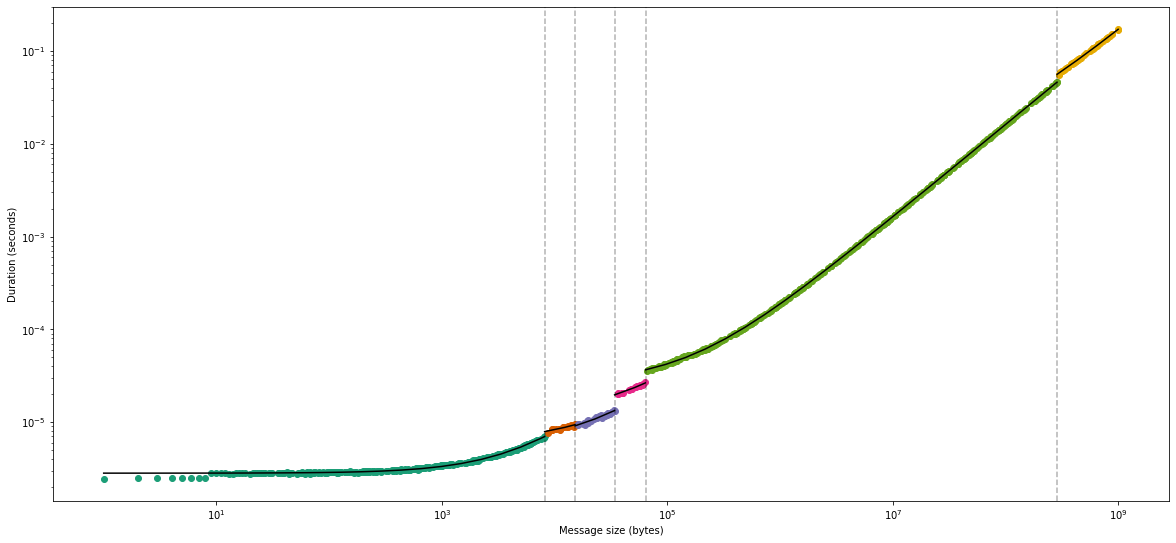

In [23]:
tmp = aggregate_dataframe(experiment['pingpong'])
reg_pingpong = pycewise.compute_regression(x=tmp.msg_size, y=tmp.duration, mode='log', breakpoints=breakpoints)
print(reg_pingpong)
draw_plot(reg_pingpong)

In the following cells, we compute the **transfer** model, using the ping-pong, recv and send regressions. In other words, we add the various piecewise regressions to generate a *new* piecewise regression, where the intercept of each segment is the network latency and the slope of each segment is the inverse of the network bandwidth.

In [24]:
df_reg_recv = reg_recv.to_pandas()
df_reg_pingpong = reg_pingpong.to_pandas()
df_reg_transfer = df_reg_pingpong[['coefficient', 'intercept', 'max_x', 'min_x']].copy()
df_reg_transfer['coefficient'] /= 2
df_reg_transfer['intercept'] /= 2
df_reg_transfer.loc[df_reg_transfer['max_x'] <= drop_thresh, 'coefficient'] -= df_reg_recv[df_reg_recv['max_x'] <= drop_thresh]['coefficient']
df_reg_transfer.loc[df_reg_transfer['max_x'] <= drop_thresh, 'intercept'] -= df_reg_recv[df_reg_recv['max_x'] <= drop_thresh]['intercept']
# A negative bandwidth or latency does not make sense 
df_reg_transfer.loc[df_reg_transfer['coefficient'] < 0, 'coefficient'] = 1/expected_bandwidth
df_reg_transfer.loc[df_reg_transfer['intercept'] < 0, 'intercept'] = 0
df_reg_transfer

,coefficient,intercept,max_x,min_x
0,1.898977e-10,1.317253e-07,8141.0,-inf
1,2.777245e-11,1.970685e-06,15182.0,8141.0
2,3.649484e-11,1.712114e-06,33975.0,15182.0
3,3.484901e-11,4.861755e-06,64000.0,33975.0
4,8.097510e-11,1.311807e-05,285420699.0,64000.0
5,8.157720e-11,4.791763e-03,inf,285420699.0


The following is only using pycewise to generate a graphical representation, we do not use the regression computed by pycewise here.

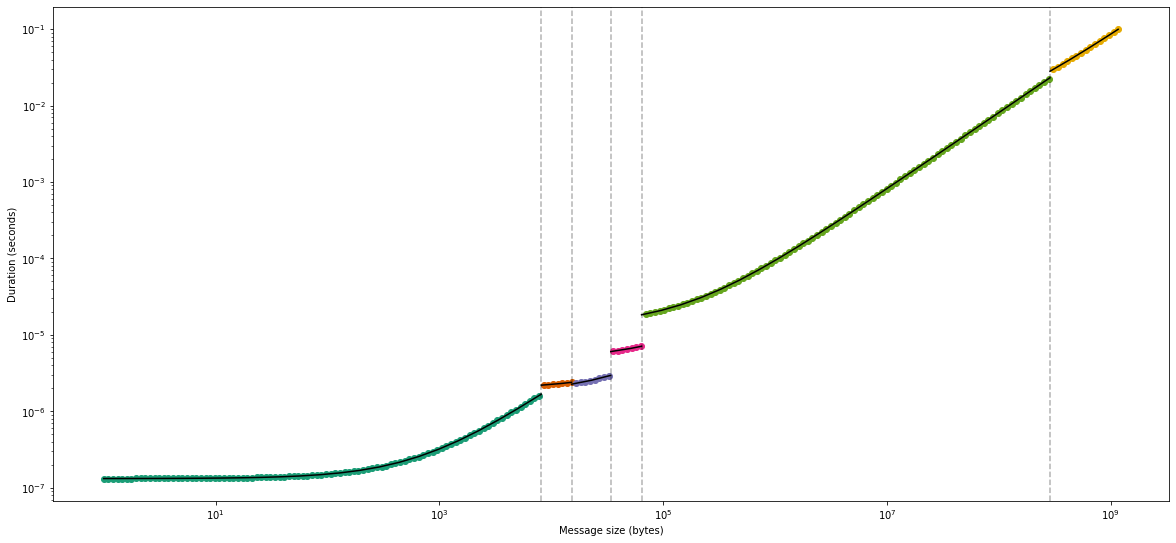

In [25]:
def predict(reg, x):
    for row in reg.iterrows():
        _, row = row
        if row.min_x <= x < row.max_x:
            return row.coefficient * x + row.intercept

tmp = pandas.DataFrame({'x': [1.1**i for i in range(220)]})
tmp['y'] = tmp.apply(lambda row: predict(df_reg_transfer, row.x), axis=1)
draw_plot(pycewise.compute_regression(x=tmp.x, y=tmp.y, breakpoints=breakpoints))

In [26]:
df_reg_transfer['bandwidth_factor'] = 1/(df_reg_transfer.coefficient*expected_bandwidth)
df_reg_transfer['latency_factor']   = df_reg_transfer.intercept/expected_latency

pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer

,coefficient,intercept,max_x,min_x,bandwidth_factor,latency_factor
0,1.90e-10,1.32e-07,8.14e+03,-inf,4.21e-01,1.32e+00
1,2.78e-11,1.97e-06,1.52e+04,8.14e+03,2.88e+00,1.97e+01
2,3.65e-11,1.71e-06,3.40e+04,1.52e+04,2.19e+00,1.71e+01
3,3.48e-11,4.86e-06,6.40e+04,3.40e+04,2.30e+00,4.86e+01
4,8.10e-11,1.31e-05,2.85e+08,6.40e+04,9.88e-01,1.31e+02
5,8.16e-11,4.79e-03,inf,2.85e+08,9.81e-01,4.79e+04


In [27]:
bandwidth_str = regression_to_str(df_reg_transfer, drop_threshold=drop_thresh, keys=['bandwidth_factor'])
latency_str = regression_to_str(df_reg_transfer, drop_threshold=drop_thresh, keys=['latency_factor'])

print(bandwidth_str)
print(latency_str)

min_lat_factor = df_reg_transfer[df_reg_transfer.min_x == float('-inf')].latency_factor.min()
max_bw_factor = df_reg_transfer[df_reg_transfer.max_x == float('inf')].bandwidth_factor.max()

0:0.421279387013144;8141:2.880552198399196;15182:2.192090650038537;33975:2.2956174029575895;64000:0.9879580636327162;285420699:0.9806662224111325
0:1.3172532760874207;8141:19.706846568053095;15182:17.121138668465882;33975:48.617546457081495;64000:131.1806875881963;285420699:47917.628671537845


### Wtime

9.4257625e-07


<AxesSubplot:>

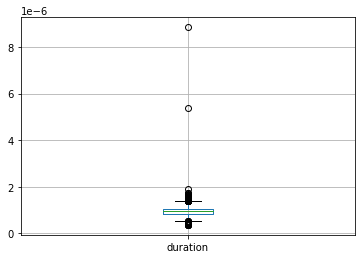

In [28]:
wtime_mean = experiment['wtime'].duration.mean()
print(wtime_mean)
experiment['wtime'].boxplot('duration')

### Test

8.194226137498865e-07


<AxesSubplot:>

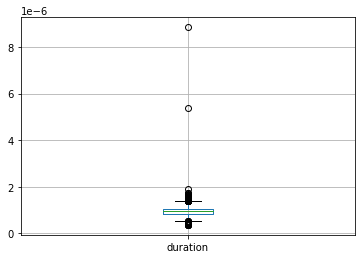

In [29]:
test_mean = experiment['test'].duration.mean()
print(test_mean)
experiment['wtime'].boxplot('duration')

### Iprobe

2.586894942676012e-07


<AxesSubplot:>

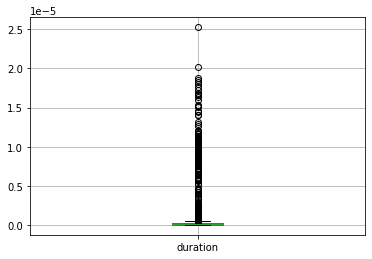

In [30]:
iprobe_mean = experiment['iprobe'].duration.mean()
print(iprobe_mean)
experiment['iprobe'].boxplot('duration')

## XML generation

In [31]:
config = f'''
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="{reg_send_str}"/>
        <prop id="smpi/or" value="{reg_recv_str}"/>
        <prop id="smpi/ois" value="{reg_isend_str}"/>
        <prop id="smpi/bw-factor" value="{bandwidth_str}"/>
        <prop id="smpi/lat-factor" value="{latency_str}"/>
        <prop id="smpi/async-small-thresh" value="{semantic_breaks[0]}"/>
        <prop id="smpi/send-is-detached-thresh" value="{semantic_breaks[1]}"/>
        <prop id="smpi/iprobe" value="{iprobe_mean}"/>
        <prop id="smpi/test" value="{test_mean}"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="{expected_bandwidth*1e-9}GBps" lat="{expected_latency*1e6:.2f}us"/>
    </AS>
</platform>
'''

# Note: I removed the wtime property because I do not need it, feel free to add it back: <prop id="smpi/wtime" value="{wtime_mean}"/>

from IPython.display import display, Markdown
display(Markdown('```xml\n%s\n```' % config))

```xml

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.569478959380802e-07:9.654903326895022e-11;8141:3.539145436762284e-06:1.3314821274741587e-10;15182:3.6144692297995343e-06:1.1444081092957802e-10;33975:7.442771050907994e-06:1.4571053896673637e-10;64000:0.0:0.0;285420699:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.2750423139975955e-06:6.613419848852234e-11;8141:1.1174370543346335e-06:7.773513740535477e-11;15182:1.1443600853337174e-06:7.53731108392213e-11;33975:1.0993400801879667e-06:7.892046873378636e-11;64000:0.0:0.0;285420699:0.0:0.0"/>
        <prop id="smpi/ois" value="0:7.713106893972037e-07:6.265045293286823e-11;8141:4.746573648378263e-07:1.1916323032290763e-10;15182:3.163310534066029e-06:3.913788923652584e-11;33975:3.3980189569161344e-06:3.104961875744934e-11;64000:8.502012071658028e-07:3.0649189436622192e-15;285420699:1.537212690372013e-06:1.0509048158790775e-16"/>
        <prop id="smpi/bw-factor" value="0:0.421279387013144;8141:2.880552198399196;15182:2.192090650038537;33975:2.2956174029575895;64000:0.9879580636327162;285420699:0.9806662224111325"/>
        <prop id="smpi/lat-factor" value="0:1.3172532760874207;8141:19.706846568053095;15182:17.121138668465882;33975:48.617546457081495;64000:131.1806875881963;285420699:47917.628671537845"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.586894942676012e-07"/>
        <prop id="smpi/test" value="8.194226137498865e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="12.5GBps" lat="0.10us"/>
    </AS>
</platform>

```

## Pretty plots (for puting in your paper)

In [32]:
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *

def pretty_plot(df, reg, n=10000):
    df = df.sample(n=n).copy()
    df['pred'] = df.apply(lambda row: reg.predict(row['msg_size']), axis=1)
    df['group'] = 0
    for i, bp in enumerate(reg.breakpoints):
        df.loc[df['msg_size'] > bp, 'group'] = i+1
    plot = ggplot(df) + geom_point(aes(x='msg_size', y='duration', color='factor(group)'), alpha=0.5, show_legend=False)
    breakpoints = list(reg.breakpoints)
    for bp in breakpoints:
        plot = plot + geom_vline(xintercept=bp, linetype='dashed', color='gray')
    breakpoints = [float('-inf')] + breakpoints + [float('inf')]
    for bp1, bp2 in zip(breakpoints[:-1], breakpoints[1:]):
        plot = plot + geom_line(df[(df.msg_size > bp1) & (df.msg_size < bp2)], aes(x='msg_size', y='pred'), size=1)
    plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + xlab('Message size (bytes)') + ylab('Duration (seconds)')
    op = df['op'].unique()[0]
    plot = plot + ggtitle('Durations of %s' % op)
    return plot

/home/tom/.cache/pypoetry/virtualenvs/notebooks-qksbUsoU-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
/home/tom/.cache/pypoetry/virtualenvs/notebooks-qksbUsoU-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/recv.pdf


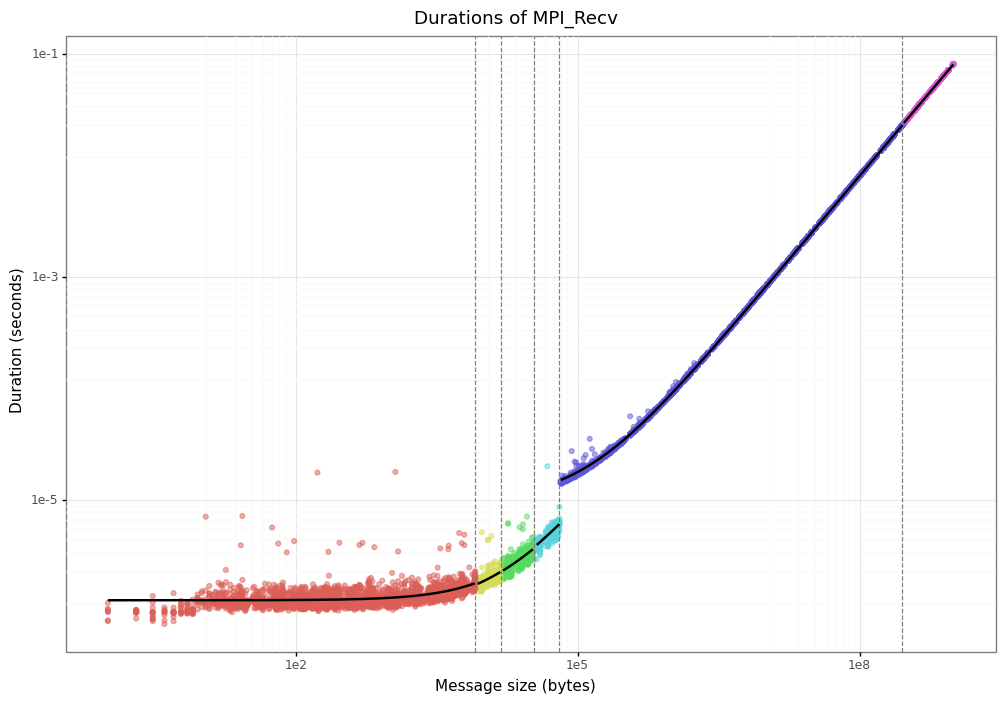

<ggplot: (-9223363253990755689)>

In [33]:
plot = pretty_plot(experiment['recv'], reg_recv)
plot.save('/tmp/recv.pdf')
plot

/home/tom/.cache/pypoetry/virtualenvs/notebooks-qksbUsoU-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
/home/tom/.cache/pypoetry/virtualenvs/notebooks-qksbUsoU-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/send.pdf


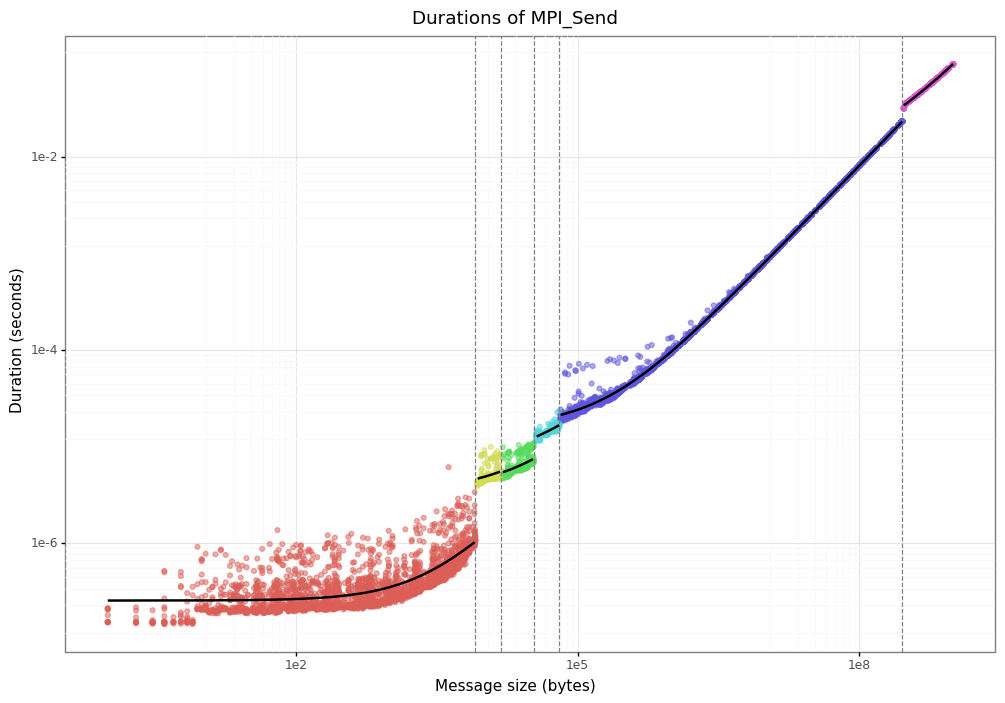

<ggplot: (8782863941917)>

In [34]:
plot = pretty_plot(experiment['send'], reg_send)
plot.save('/tmp/send.pdf')
plot